### This notebook will be using past volatility and past returns for the some stock indexes and USDBRL in order to try to build a multiple linear regression model in order to predict the IBOVESPA returns in the next 30 days:

### Importing necessary modules:

In [34]:
# Modules for working with the data:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as dt

# Machine learning modules:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression

### Importing and structuring data:

##### We will be using 30, 63 and 126 days for calculating past returns and past volatility

In [35]:
# Tickers we will be using:
tickers = ["USDBRL=X","^BVSP","^GSPC","SMAL11.SA"]
data_daily_prices = pd.DataFrame()

# Getting the data:
for i in tickers: 
    data_daily_prices[i]=dt.DataReader(i,data_source="yahoo",start="2010")["Adj Close"]


data_daily_prices.dropna(inplace=True)
data_daily_prices.columns = ["USDBRL","IBOV","SP500","SMAL11"]
data_daily_returns=data_daily_prices.pct_change().dropna()

# Calculating past returns and past volatility for every asset:
vol_30 = data_daily_returns.rolling(window=30).std().dropna().add_suffix("V30")
vol_63 = data_daily_returns.rolling(window=63).std().dropna().add_suffix("V63")
vol_126 = data_daily_returns.rolling(window=126).std().dropna().add_suffix("V126")
ret_30 = data_daily_prices.pct_change(30).dropna().add_suffix("R30")
ret_63 = data_daily_prices.pct_change(63).dropna().add_suffix("R63")
ret_126 = data_daily_prices.pct_change(126).dropna().add_suffix("R126")
ibov_next = data_daily_prices[["IBOV"]].pct_change(-30).add_suffix("NR30")

# Joining the data:
data = pd.concat([vol_30,vol_63,vol_126,ret_30,ret_63,ret_126,ibov_next],axis=1).dropna()
data.index = list(range(len(data)))
data

,USDBRLV30,IBOVV30,SP500V30,SMAL11V30,USDBRLV63,IBOVV63,SP500V63,SMAL11V63,USDBRLV126,IBOVV126,...,SMAL11R30,USDBRLR63,IBOVR63,SP500R63,SMAL11R63,USDBRLR126,IBOVR126,SP500R126,SMAL11R126,IBOVNR30
0,0.007373,0.012181,0.014188,0.013096,0.012674,0.016716,0.016783,0.015064,0.011377,0.014516,...,0.136223,-0.010390,-0.048938,-0.049897,0.092262,0.019546,-0.025312,-0.005075,0.067591,-0.013809
1,0.006898,0.012145,0.014193,0.013075,0.011977,0.016598,0.016742,0.015039,0.011340,0.014515,...,0.123828,0.023344,-0.031184,-0.059065,0.097711,0.009499,-0.026025,-0.009423,0.072227,-0.014662
2,0.006891,0.012084,0.013556,0.013529,0.011741,0.016622,0.016744,0.015185,0.011337,0.014518,...,0.104496,0.002864,-0.041389,-0.058056,0.078504,0.011262,-0.040535,-0.008222,0.051541,-0.035846
3,0.006972,0.012240,0.013606,0.013538,0.011755,0.016651,0.016686,0.015141,0.011339,0.014537,...,0.103417,0.005714,-0.053664,-0.074002,0.066215,0.012134,-0.045819,-0.018070,0.041596,-0.056956
4,0.006911,0.012899,0.014561,0.013531,0.011762,0.016834,0.017029,0.015130,0.011341,0.014656,...,0.104496,0.007004,-0.067126,-0.100853,0.070980,0.021074,-0.063661,-0.048481,0.041200,-0.067351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117,0.016134,0.015491,0.009394,0.017130,0.019821,0.017812,0.013856,0.025115,0.016212,0.036532,...,0.069733,0.026019,0.291073,0.204990,0.328324,0.321010,-0.133561,0.030149,-0.172190,0.051661
2118,0.016200,0.015500,0.009388,0.017387,0.019991,0.017831,0.013839,0.025092,0.016347,0.036538,...,0.040516,0.036291,0.261127,0.197945,0.271806,0.346081,-0.137728,0.035720,-0.189383,0.017106
2119,0.015821,0.016049,0.009384,0.018285,0.019741,0.017885,0.013762,0.025093,0.016358,0.036579,...,0.060455,0.001558,0.264950,0.210934,0.271877,0.342685,-0.130066,0.030914,-0.175476,0.036161
2120,0.014584,0.015878,0.007820,0.017395,0.019774,0.017875,0.013788,0.025019,0.016345,0.036592,...,0.083170,0.004211,0.265849,0.206251,0.280632,0.340248,-0.142631,0.027931,-0.190573,0.015302


### Building train and test sets:

In [36]:
# 50% of the data for testing and other 50% for training:
x_train,x_test,y_train,y_test  = train_test_split(data[data.columns[:-1]],data[data.columns[-1]],test_size=0.5)

### Building the linear regression model:

In [37]:
model = LinearRegression()
model.fit(x_train,y_train);

### Running the model in the test set:

In [38]:
y_predicted = model.predict(x_test)

### Plotting the results: 

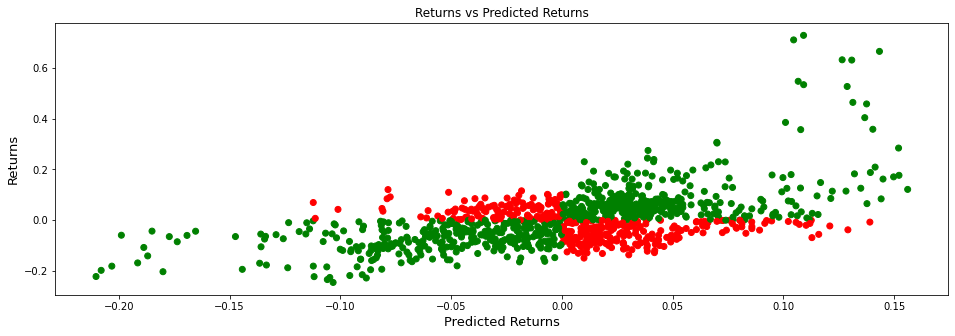

In [44]:
plt.figure(figsize=(16,5))
plt.scatter(y_predicted,y_test,c=np.where(np.sign(y_predicted)==np.sign(y_test),"green","red"))
plt.xlabel("Predicted Returns",fontsize=13)
plt.title("Returns vs Predicted Returns")
plt.ylabel("Returns",fontsize=13);

#### Mean Squared Error:

In [40]:
mse = MSE(y_test,y_predicted)
print("MSE = "+str(mse))

MSE = 0.007597782924752504
